In [28]:
%run "../config.py"

declared 4 variables


In [29]:
import os
import zipfile

In [30]:
file_name = "sign-language-img.zip"
zip_file = zipfile.ZipFile(os.path.join(DATA_DIR, file_name))
zip_file.extractall(extracted := os.path.join(TMP_DIR, file_name))
zip_file.close()

In [31]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import string
# import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

In [32]:
train_dir = os.path.join(extracted, "Train")
test_dir = os.path.join(extracted, "Test")

In [33]:
train_datagen = ImageDataGenerator(
    rescale = 1/255
)
test_datagen = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.2
)

In [34]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28,28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28,28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28,28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [35]:
classes = [char for char in string.ascii_uppercase if char != "J" and char != "Z"]
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

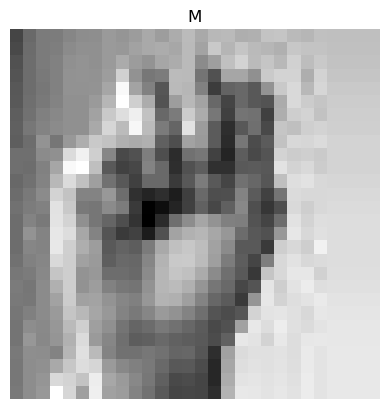

In [36]:
plt.imshow((it := next(train_generator))[0][0])
plt.title(classes[np.argmax(it[1][0])])
plt.show()

In [37]:
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.regularizers import l1_l2, l1, l2
from keras.activations import relu, softmax, elu, selu
from keras.optimizers import adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import CSVLogger, ModelCheckpoint, Callback, EarlyStopping

In [38]:
model_base = Sequential()
model_base.add( Conv2D(filters=3, activation=relu, kernel_size=(3,3), padding='same', input_shape=(28,28,1) ))
model_base.add( Conv2D(filters=3, activation=relu, kernel_size=(4,4)) )
model_base.add( MaxPool2D(pool_size=(2,2)) )
model_base.add( Flatten() )
model_base.add( Dense(256, activation=relu, kernel_regularizer=l1(1e-5)) )
model_base.add( Dropout(0.2) )
model_base.add( Dense(128, activation=relu, kernel_regularizer=l1(1e-5)) )
model_base.add( Dropout(0.2) )
model_base.add( Dense(len(classes), activation=softmax) )

In [39]:
class TrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("categorical_accuracy") > 0.95:
            print("Reached 0.95 of accuracy")
            self.model.stop_training = True

In [40]:
model_base.compile(
    optimizer=adam(),
    loss=categorical_crossentropy,
    metrics=[categorical_accuracy],
)

In [41]:
model_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 3)         30        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 3)         147       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               110848    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
__________

In [43]:
logfile_name = "D256-D128-classes.csv"
modelfile_name = "model1.hdf5"
checkpoint_callback = ModelCheckpoint(
    filepath=str(MODELS_DIR.joinpath(modelfile_name)),
    save_best_only=True,
    save_weights_only=False,
    monitor="val_loss",
)

early_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
)

history = model_base.fit_generator(
    train_generator,
    # batch_size=128,
    callbacks=[
        CSVLogger(filename=str(LOGS_DIR.joinpath(logfile_name))),
        checkpoint_callback,
        early_callback,
        # TrainingCallback()
    ],
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=250,
    validation_steps=10
)

Epoch 1/20
250/250 [==============================] - 22s 89ms/step - loss: 1.6104 - categorical_accuracy: 0.5316 - val_loss: 0.8450 - val_categorical_accuracy: 0.7680
Epoch 2/20
250/250 [==============================] - 10s 38ms/step - loss: 0.4097 - categorical_accuracy: 0.8947 - val_loss: 0.5997 - val_categorical_accuracy: 0.8392
Epoch 3/20
250/250 [==============================] - 5s 18ms/step - loss: 0.1980 - categorical_accuracy: 0.9667 - val_loss: 0.5344 - val_categorical_accuracy: 0.8683
Epoch 4/20
250/250 [==============================] - 5s 18ms/step - loss: 0.1387 - categorical_accuracy: 0.9858 - val_loss: 0.5830 - val_categorical_accuracy: 0.8666
Epoch 5/20
250/250 [==============================] - 5s 19ms/step - loss: 0.1184 - categorical_accuracy: 0.9920 - val_loss: 0.5769 - val_categorical_accuracy: 0.8640
Epoch 6/20
250/250 [==============================] - 5s 19ms/step - loss: 0.1053 - categorical_accuracy: 0.9947 - val_loss: 0.5450 - val_categorical_accuracy: 0.8

In [56]:
import json

In [69]:
with open(MODELS_DIR.joinpath("model1.json"), "w") as f:
    f.writelines(model_base.to_json())

In [45]:
model_base.evaluate_generator(test_generator, steps=100)

[0.6011433743384781, 0.8771694540864626]

In [46]:
import pandas as pd

In [47]:
history_df = pd.read_csv(LOGS_DIR.joinpath(logfile_name), index_col='epoch')

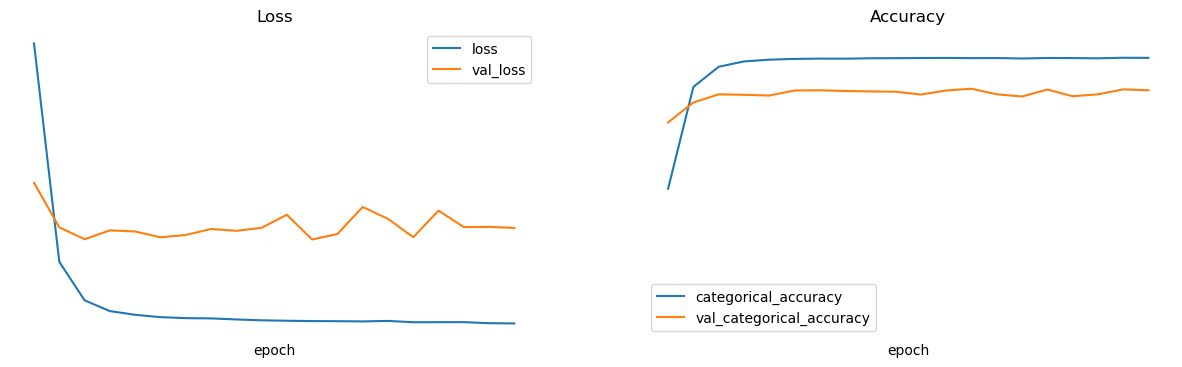

In [48]:
fig, axes = plt.subplots(1,2, figsize=(15,4), sharex=True)
history_df.loss.plot(ax=axes[0])
history_df.val_loss.plot(ax=axes[0])
history_df.categorical_accuracy.plot(ax=axes[1])
history_df.val_categorical_accuracy.plot(ax=axes[1])
axes[0].legend()
axes[0].set_title("Loss")
axes[1].legend()
axes[1].set_title("Accuracy")
axes[1].set_ylim(0,1.1)
axes[1].set_xticks(history_df.index, rot=45)
plt.show()

In [49]:
from typing import Generator

early_callback = EarlyStopping(
    monitor = "val_loss",
    patience=5,
    restore_best_weights=True
)

def generate_model(train, validation, params):
    
    if not params.__getattribute__:
        raise Exception("params doesnt seem to be a dict datatype")

    model = Sequential()
    model.add( Conv2D(filters=params["filters"], activation=params["activation"], kernel_size=(3,3), padding='same', input_shape=(28,28,1) ))
    model.add( MaxPool2D(pool_size=(2,2)) )
    model.add( Flatten() )
    model.add( Dense(params["dense1"], activation=params["activation"], kernel_regularizer=l1(1e-5)) )
    model.add( Dropout(params["dropout1"]) )
    model.add( Dense(params["dense2"], activation=params["activation"], kernel_regularizer=l1(1e-5)) )
    model.add( Dropout(params["dropout2"]) )
    model.add( Dense(len(classes), activation=softmax) )

    model.compile(
        optimizer=adam(params["lr"]),
        loss=categorical_crossentropy,
        metrics=categorical_accuracy
    )

    if isinstance(train, Generator) and isinstance(validation, Generator):
        fit_method = model.fit_generator
        out = fit_method(
            train,
            # batch_size=128,
            callbacks=[ early_callback ],
            validation_data=validation,
            epochs=20,
            steps_per_epoch=250,
            validation_steps=10
        )
    elif isinstance(train, tuple) and isinstance(validation, tuple):
        fit_method = model.fit
        out = fit_method(
            x = train[0],
            y = train[1],
            batch_size=128,
            callbacks=[ early_callback ],
            validation_data=validation,
            epochs=20,
            # steps_per_epoch=250,
            # validation_steps=10
        )

    return out, model

In [50]:
hp = {
    "filters": np.arange(2,64,8, dtype=np.int_),
    "activation": [relu, elu, selu],
    "desnse1": np.arange(16,76,5, dtype=np.int_),
    "dense2": np.arange(16,32,5, dtype=np.int_),
    "dropout1": np.arange(0.1,0.3, 0.5),
    "dropout2": np.arange(0.1,0.3, 0.5),
    "lr": np.arange(0.0001,0.01, 0.001)
}

In [51]:
pred_.argmax(axis=1)

array([20,  9, 23, ..., 23,  4,  6])

In [52]:
import cv2

In [53]:
def decode(img):
    img = np.expand_dims(img, axis=2)
    idx = model_base.predict(np.array([img])).argmax()
    pred = list(train_generator.class_indices.keys())[idx]
    return pred

In [70]:
import pickle

In [72]:
with open(DATA_DIR.joinpath("decoder.pickle"), "wb") as f:
    pickle.dump(train_generator.class_indices, f)

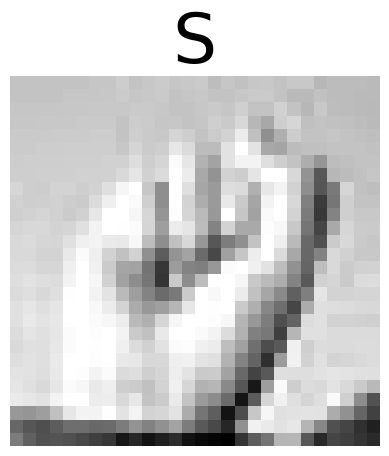

In [54]:
img = cv2.imread("/tmp/sign-language-img.zip/Test/S/287_S.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.title(decode(img), size=50)
plt.show()